In [1]:
# import supporting libraries
import torch
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from io import BytesIO

# set seed to ensure reproducibility
torch.manual_seed(8)

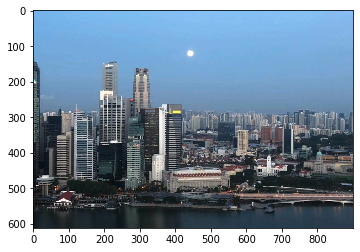

In [2]:
url = 'https://raw.githubusercontent.com/jackliu333/regularization_in_deep_learning/main/Image.png'
# initiate an HTTP request via the get method
response = requests.get(url)
# access the content of the response to retrieve the image
img = Image.open(BytesIO(response.content))
# convert to numpy array
img = np.array(img)
# ignore the fourth channel since it's not needed
img = img[...,:3]

plt.imshow(img, interpolation='nearest')
plt.show()

In [3]:
# specify the data augmentation scheme
img_augment = transforms.Compose([transforms.RandomHorizontalFlip(), # flip the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     # rotate the image up to 10 degress
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # randomly changes image brightness, contrast and saturation up to a certain degree
                                      transforms.ToTensor() # convert to tensor object to work with torch
                               ])

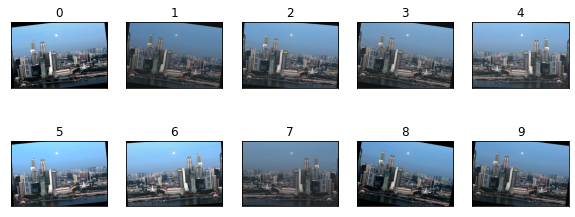

In [4]:
import copy 
def gen_img(img):
    # convert to PIL image format using a copied instance
    img2 = transforms.ToPILImage()(copy.copy(img))
    # apply data augmentation
    img2 = img_augment(img2) 
    # move the color channel to the last for plotting purpose
    img2 = np.transpose(img2, (1, 2, 0))
    return img2

fig = plt.figure(figsize=(10, 4)) 

# plot 10 randomly generated images
for idx in np.arange(10):
  ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[]) 
  plt.imshow(gen_img(img)) 
  ax.set_title(idx)

# Training without data augmentation

In [5]:
# transformation steps for training and test set upon loading the dataset
transform = transforms.Compose([transforms.ToTensor(), 
                                      transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                           std=(0.5, 0.5, 0.5))])
# download the CIFAR10 dataset
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, 
                                    transform=transform) 
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, 
                                      transform=transform)
# define data loader that reads 100 images at a time
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, 
                                              shuffle=True) 
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size = 100, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


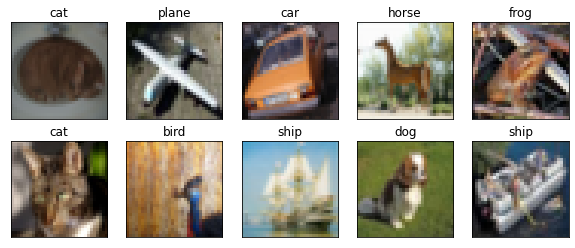

In [6]:
# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
# format the image for plotting
def convert_tensor_to_np(tensor_img):  
  # convert to numpy
  image = tensor_img.clone().numpy() 
  # move color channel to the last
  image = image.transpose(1, 2, 0)
  # unscale the image back to [0,1]
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

# get some random training images from the first batch
dataiter = iter(training_loader)
images, labels = dataiter.next()
# define the class labels for visualizing purpose
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
# plot the images in a 2x5 grid
fig = plt.figure(figsize=(10, 4)) 
for idx in np.arange(10):
  ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[]) 
  plt.imshow(convert_tensor_to_np(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, 
                              stride=1, padding=1) 
        # double the depth of feature maps for every conv layer
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1) 
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        # input image is 32*32, after 3 MaxPooling layers it reduces to 4*4 64 feature maps
        self.fc1 = nn.Linear(4*4*64, 500) 
        self.dropout1 = nn.Dropout(0.5)
        # 10 output nodes that map to 10 classes
        self.fc2 = nn.Linear(500, 10) 

    def forward(self, x):
        # apply relu to each conv layer output
        x = F.relu(self.conv1(x)) 
        # max pooling layer with 2x2 kernel to shrink the size by half
        x = F.max_pool2d(x, 2, 2) 
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        # flatten the images as 1D input to the fully connected layer
        x = x.view(-1, 4*4*64) 
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [20]:
# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device) 
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [21]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [ ]:
%%time

epochs = 1000
training_loss_history = []
training_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for e in range(epochs): 
    training_loss = 0.0
    training_accuracy = 0.0
    val_loss = 0.0
    val_accuracy = 0.0
    # iterate over each batch of training set
    for inputs, labels in training_loader:
        # send to GPU for faster training
        inputs = inputs.to(device) 
        labels = labels.to(device)
        # get logit output
        outputs = model(inputs) 
        # calculate CRE loss
        loss = criterion(outputs, labels) 
        # clear existing gradients
        optimizer.zero_grad() 
        # backpropagate the loss
        loss.backward() 
        # update the weights
        optimizer.step() 
        # take the indexes of maximum logits as class prediction
        _, preds = torch.max(outputs, 1) 
        training_loss += loss.item()
        # count the correct predictions in a batch
        training_accuracy += torch.sum(preds == labels.data) 
    # check validation performance without gradient evaluation
    with torch.no_grad(): 
        for val_inputs, val_labels in validation_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss_model = criterion(val_outputs, val_labels)
            _, val_preds = torch.max(val_outputs, 1)
            val_loss += val_loss_model.item()
            val_accuracy += torch.sum(val_preds == val_labels.data)
    # average loss per epoch
    epoch_loss = training_loss/len(training_loader) 
    val_epoch_loss = val_loss/len(validation_loader)
    # accuracy per epoch
    epoch_acc = training_accuracy.float()/ len(training_loader) 
    val_epoch_acc = val_accuracy.float()/ len(validation_loader)
    # append to master list for visualization
    training_loss_history.append(epoch_loss) 
    training_accuracy_history.append(epoch_acc.item())
    val_loss_history.append(val_epoch_loss)
    val_accuracy_history.append(val_epoch_acc.item())
    print('Epoch :', (e+1))
    print('Training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('Validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

Epoch : 1
Training loss: 2.2981, acc 13.2380 
Validation loss: 2.2900, validation acc 14.4500 
Epoch : 2
Training loss: 2.2444, acc 17.7220 
Validation loss: 2.1199, validation acc 24.5500 
Epoch : 3
Training loss: 2.0123, acc 27.9200 
Validation loss: 1.9079, validation acc 32.3200 
Epoch : 4
Training loss: 1.8258, acc 34.5800 
Validation loss: 1.7278, validation acc 37.9600 
Epoch : 5
Training loss: 1.6852, acc 38.9380 
Validation loss: 1.6184, validation acc 40.6500 
Epoch : 6
Training loss: 1.6063, acc 41.4200 
Validation loss: 1.5713, validation acc 42.6700 
Epoch : 7
Training loss: 1.5496, acc 43.4640 
Validation loss: 1.5135, validation acc 44.5400 
Epoch : 8
Training loss: 1.5021, acc 45.3000 
Validation loss: 1.4639, validation acc 46.4500 
Epoch : 9
Training loss: 1.4574, acc 47.0440 
Validation loss: 1.4339, validation acc 47.8900 
Epoch : 10
Training loss: 1.4142, acc 48.9080 
Validation loss: 1.4096, validation acc 49.0500 
Epoch : 11
Training loss: 1.3789, acc 50.1860 
Va

In [ ]:
plt.rcParams["figure.figsize"] = (15,6)
fig=plt.figure()
plt.subplot(121)
plt.plot(training_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.subplot(122)
plt.plot(training_accuracy_history, label='training accuracy')
plt.plot(val_accuracy_history, label='validation accuracy')
plt.legend()

# Training with data augmentation

In [12]:
transform_aug = transforms.Compose([transforms.RandomHorizontalFlip(), # flip the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     # rotate the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, 
                                                              scale=(0.8,1.2)), # zoom and shear
                                      transforms.ColorJitter(brightness=0.2, 
                                                             contrast=0.2, 
                                                             saturation=0.2), # change color
                                      transforms.ToTensor(),  
                                      transforms.Normalize((0.5, 0.5, 0.5), 
                                                           (0.5, 0.5, 0.5)) 
                               ])
training_dataset_aug = datasets.CIFAR10(root='./data_aug', train=True, 
                                        download=True, transform=transform_aug) 
training_loader_aug = torch.utils.data.DataLoader(training_dataset_aug, 
                                                  batch_size=100, shuffle=True) 

Files already downloaded and verified


In [13]:
model_aug = LeNet().to(device) 
optimizer_aug = torch.optim.SGD(model_aug.parameters(), lr = 0.01)

In [14]:
%%time

epochs = 100
training_loss_history_aug = []
training_accuracy_history_aug = []
val_loss_history_aug = []
val_accuracy_history_aug = []

for e in range(epochs): 
    training_loss = 0.0
    training_accuracy = 0.0
    val_loss = 0.0
    val_accuracy = 0.0
    # iterate over each batch of training set
    for inputs, labels in training_loader_aug:
        # send to GPU for faster training
        inputs = inputs.to(device) 
        labels = labels.to(device)
        # get logit output
        outputs = model_aug(inputs) 
        # calculate CRE loss
        loss = criterion(outputs, labels) 
        # clear existing gradients
        optimizer_aug.zero_grad() 
        # backpropagate the loss
        loss.backward() 
        # update the weights
        optimizer_aug.step() 
        # take the indexes of maximum logits as class prediction
        _, preds = torch.max(outputs, 1) 
        training_loss += loss.item()
        # count the correct predictions in a batch
        training_accuracy += torch.sum(preds == labels.data) 
    # check validation performance without gradient evaluation
    with torch.no_grad(): 
        for val_inputs, val_labels in validation_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model_aug(val_inputs)
            val_loss_model = criterion(val_outputs, val_labels)
            _, val_preds = torch.max(val_outputs, 1)
            val_loss += val_loss_model.item()
            val_accuracy += torch.sum(val_preds == val_labels.data)
    # average loss per epoch
    epoch_loss = training_loss/len(training_loader) 
    val_epoch_loss = val_loss/len(validation_loader)
    # accuracy per epoch
    epoch_acc = training_accuracy.float()/ len(training_loader) 
    val_epoch_acc = val_accuracy.float()/ len(validation_loader)
    # append to master list for visualization
    training_loss_history_aug.append(epoch_loss) 
    training_accuracy_history_aug.append(epoch_acc.item())
    val_loss_history_aug.append(val_epoch_loss)
    val_accuracy_history_aug.append(val_epoch_acc.item())
    print('Epoch :', (e+1))
    print('Training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('Validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

tensor(6335., device='cuda:0')
Epoch : 1
Training loss: 2.2967, acc 12.6700 
Validation loss: 2.2847, validation acc 17.8600 
tensor(9552., device='cuda:0')
Epoch : 2
Training loss: 2.2268, acc 19.1040 
Validation loss: 2.1035, validation acc 23.9500 
tensor(12651., device='cuda:0')
Epoch : 3
Training loss: 2.0390, acc 25.3020 
Validation loss: 1.9512, validation acc 29.7200 
tensor(15028., device='cuda:0')
Epoch : 4
Training loss: 1.9299, acc 30.0560 
Validation loss: 1.8435, validation acc 33.5100 
tensor(16750., device='cuda:0')
Epoch : 5
Training loss: 1.8367, acc 33.5000 
Validation loss: 1.7302, validation acc 38.0900 
tensor(18254., device='cuda:0')
Epoch : 6
Training loss: 1.7540, acc 36.5080 
Validation loss: 1.6494, validation acc 39.8800 
tensor(19505., device='cuda:0')
Epoch : 7
Training loss: 1.6841, acc 39.0100 
Validation loss: 1.5926, validation acc 42.2500 
tensor(20554., device='cuda:0')
Epoch : 8
Training loss: 1.6286, acc 41.1080 
Validation loss: 1.5344, validation

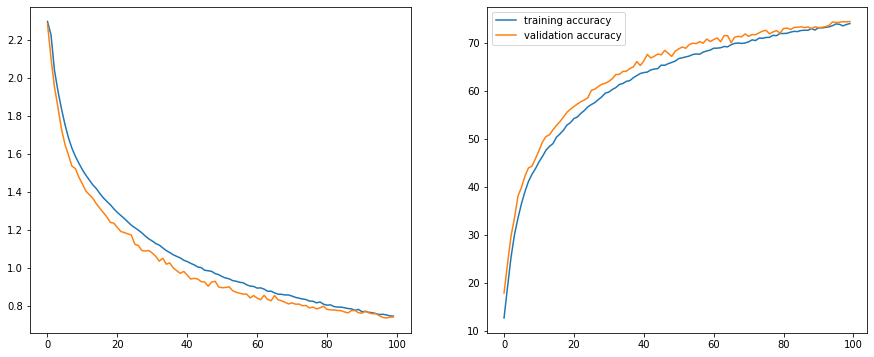

In [15]:
plt.rcParams["figure.figsize"] = (15,6)
fig=plt.figure()
plt.subplot(121)
plt.plot(training_loss_history_aug, label='training loss')
plt.plot(val_loss_history_aug, label='validation loss')
plt.subplot(122)
plt.plot(training_accuracy_history_aug, label='training accuracy')
plt.plot(val_accuracy_history_aug, label='validation accuracy')
plt.legend()